In [6]:
import os
import pandas as pd
import matplotlib.pyplot as plt

In [40]:
ticker = "NVDA"
interval = "daily"
target_date_string = "2025-12-01"
lookback_days = 22

raw_path = f"../../../data/raw/{ticker}/{interval}/data.parquet"
features_dir = f"../../../data/features/{ticker}/{interval}"
features_path = f"{features_dir}/data.parquet"

In [41]:
raw_df = pd.read_parquet(raw_path, engine='pyarrow')
raw_df['Date'] = pd.to_datetime(raw_df['Date'])
raw_df.set_index('Date', inplace=True)
raw_df.head()

,Ticker,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,,
2023-01-03,NVDA,14.300683,14.315,14.996,14.096,14.851,401277000
2023-01-04,NVDA,14.734250,14.749,14.853,14.241,14.567,431324000
2023-01-05,NVDA,14.250735,14.265,14.564,14.148,14.491,389168000
2023-01-06,NVDA,14.844137,14.859,15.010,14.034,14.474,405044000
2023-01-09,NVDA,15.612371,15.628,16.056,15.141,15.284,504231000


<Axes: xlabel='Date'>

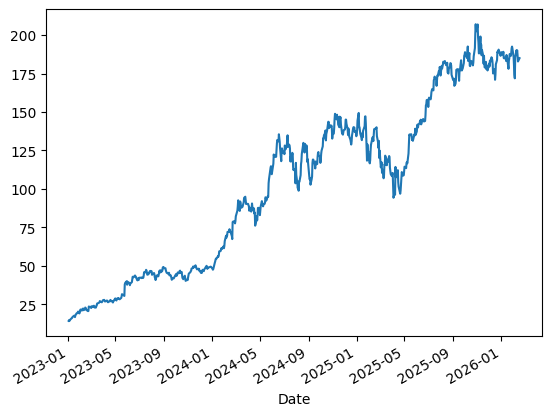

In [42]:
raw_df['Adj Close'].plot()

In [46]:
features_df = pd.read_parquet(features_path, engine='pyarrow')
features_df['Date'] = pd.to_datetime(features_df['Date'])
features_df.set_index('Date', inplace=True)
# features_df = features_df.dropna(subset=['SMA_50'])
features_df.tail()

,Ticker,Adj Close,Close,High,Low,Open,Volume,RSI,SMA_20,SMA_50,EMA_20,MACD,MACD_Signal,MACD_Hist
Date,,,,,,,,,,,,,,
2026-02-10,NVDA,188.539993,188.539993,192.479996,188.119995,191.380005,136764800,52.370633,185.114500,183.976001,184.955115,-0.126330,-0.180749,0.054419
2026-02-11,NVDA,190.050003,190.050003,193.259995,188.770004,192.449997,144192700,53.453097,185.326501,184.237198,185.440343,0.298011,-0.084997,0.383008
2026-02-12,NVDA,186.940002,186.940002,193.610001,186.509995,193.029999,189932500,51.279100,185.516501,184.377799,185.583168,0.378985,0.007799,0.371186
2026-02-13,NVDA,182.809998,182.809998,187.500000,181.589996,187.479996,161888000,48.158153,185.304501,184.405001,185.319056,0.108648,0.027969,0.080679
2026-02-17,NVDA,184.970001,184.970001,187.149994,179.179993,181.750000,161639600,51.130608,185.241501,184.512801,185.285813,0.067916,0.035958,0.031957


<Axes: xlabel='Date'>

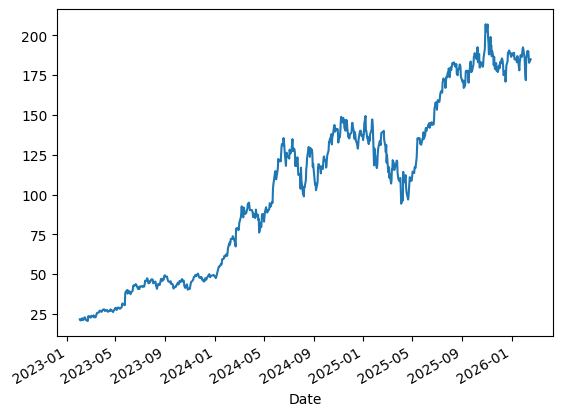

In [44]:
features_df['Adj Close'].plot()

In [53]:
import numpy as np
def generate_signals(df, rsi_lower=35, rsi_upper=65):
    signals_df = df.copy()
    signals_df['Signal'] = np.nan
    signals_df.loc[signals_df['RSI'] < rsi_lower, 'Signal'] = 1
    signals_df.loc[signals_df['RSI'] > rsi_upper, 'Signal'] = 0
    signals_df['Position'] = signals_df['Signal'].ffill().fillna(0)
    signals_df['Position'] = signals_df['Position'].shift(1).fillna(0)
    return signals_df

df = generate_signals(features_df)
df.head()

,Ticker,Adj Close,Close,High,Low,Open,Volume,RSI,SMA_20,SMA_50,EMA_20,MACD,MACD_Signal,MACD_Hist,Signal,Position
Date,,,,,,,,,,,,,,,,
2023-02-02,NVDA,21.687286,21.709000,21.948999,20.700001,21.000000,564276000,79.243786,17.934746,NaN,18.365354,1.534741,1.249924,0.284816,0.0,0.0
2023-02-03,NVDA,21.078896,21.100000,21.745001,20.789000,21.000000,429366000,75.601837,18.276154,NaN,18.623786,1.558705,1.311680,0.247025,0.0,0.0
2023-02-06,NVDA,21.067911,21.089001,21.570000,20.785999,20.806000,452197000,74.711589,18.587343,NaN,18.856560,1.558842,1.361113,0.197729,0.0,0.0
2023-02-07,NVDA,22.150826,22.173000,22.259001,21.150000,21.382000,664150000,79.445947,18.914266,NaN,19.170300,1.627571,1.414404,0.213167,0.0,0.0
2023-02-08,NVDA,22.182793,22.205000,22.878000,22.007999,22.386999,559651000,78.548129,19.228751,NaN,19.457204,1.665421,1.464608,0.200813,0.0,0.0


In [60]:
def extract_trade_log(df):
    """
    Scans the vectorized backtest DataFrame, groups the 1s and 0s into 
    discrete trades, and calculates the win rate and average profit.
    """
    pos = df['Position'].fillna(0)
    changes = pos.diff()
    
    # 1. Grab the exact dates from the Index where changes happen
    entries = df[changes == 1].index
    exits = df[changes == -1].index
    
    # Force-close any open positions at the end of the dataset
    if len(entries) > len(exits):
        exits = exits.append(pd.Index([df.index[-1]]))
        
    trade_ledger = []
    
    for entry_date, exit_date in zip(entries, exits):
        
        # Calculate compounded return for this specific holding period
        trade_returns = df.loc[entry_date:exit_date, 'Strategy_Return']
        trade_profit = (1 + trade_returns).prod() - 1
        
        # Calculate holding period (Calendar Days vs Trading Days)
        calendar_days = (exit_date - entry_date).days
        trading_days = df.index.get_loc(exit_date) - df.index.get_loc(entry_date)
        
        trade_ledger.append({
            'Entry_Date': entry_date,
            'Exit_Date': exit_date,
            'Trading_Days': trading_days,
            'Calendar_Days': calendar_days,
            'Return': trade_profit
        })
        
    trades_df = pd.DataFrame(trade_ledger)
    
    # 2. Calculate the Holy Grail Metrics
    if len(trades_df) > 0:
        winning_trades = trades_df[trades_df['Return'] > 0]
        losing_trades = trades_df[trades_df['Return'] <= 0]
        
        win_rate = len(winning_trades) / len(trades_df)
        avg_win = winning_trades['Return'].mean() if not winning_trades.empty else 0
        avg_loss = losing_trades['Return'].mean() if not losing_trades.empty else 0
        
        print(f"\n=== TRADE LOG SUMMARY ===")
        print(f"Total Trades Taken: {len(trades_df)}")
        print(f"Win Rate:           {win_rate:.2%}")
        print(f"Average Win:        {avg_win:.2%}")
        print(f"Average Loss:       {avg_loss:.2%}")
        print(f"Best Trade:         {trades_df['Return'].max():.2%}")
        print(f"Worst Trade:        {trades_df['Return'].min():.2%}")
        print("=========================\n")
    else:
        print("\n[!] No trades executed during this period.")
        
    return trades_df

In [61]:
# The baseline asset return (Buy & Hold)
df['Asset_Return'] = df['Adj Close'].pct_change()

# The strategy return (We only capture the asset return when Position == 1)
df['Strategy_Return'] = df['Asset_Return'] * df['Position']

# Calculate Equity Curves (Cumulative compounding)
# We add 1 to the returns and calculate the cumulative product
df['Asset_Equity'] = (1 + df['Asset_Return']).cumprod()
df['Strategy_Equity'] = (1 + df['Strategy_Return']).cumprod()

# Fill the first row (NaN) with 1.0 so our charts start cleanly at 100%
df['Asset_Equity'] = df['Asset_Equity'].fillna(1.0)
df['Strategy_Equity'] = df['Strategy_Equity'].fillna(1.0)

trade_log_df = extract_trade_log(df)

# Print the Performance Dashboard
total_asset_return = df['Asset_Equity'].iloc[-1] - 1
total_strategy_return = df['Strategy_Equity'].iloc[-1] - 1

print(f"=== {ticker} BASELINE BACKTEST RESULTS ===")
print(f"Total Trading Days: {len(df)}")
print(f"Buy & Hold Return:  {total_asset_return:.2%}")
print(f"Strategy Return:    {total_strategy_return:.2%}")
print(f"Performance Delta:  {(total_strategy_return - total_asset_return):.2%}")
print("=========================================\n")


=== TRADE LOG SUMMARY ===
Total Trades Taken: 4
Win Rate:           100.00%
Average Win:        25.60%
Average Loss:       0.00%
Best Trade:         37.77%
Worst Trade:        19.27%

=== NVDA BASELINE BACKTEST RESULTS ===
Total Trading Days: 762
Buy & Hold Return:  752.90%
Strategy Return:    147.21%
Performance Delta:  -605.69%



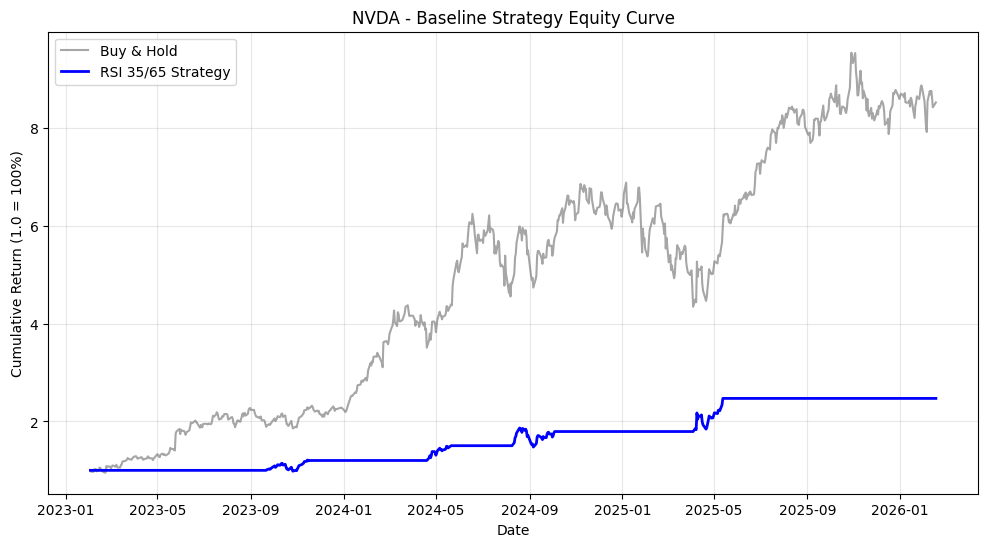

In [57]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Asset_Equity'], label='Buy & Hold', color='gray', alpha=0.7)
plt.plot(df.index, df['Strategy_Equity'], label='RSI 35/65 Strategy', color='blue', linewidth=2)

plt.title(f'{ticker} - Baseline Strategy Equity Curve')
plt.xlabel('Date')
plt.ylabel('Cumulative Return (1.0 = 100%)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()